# Feature Engineering — Video Game Sales Analysis

**Purpose:** Transform raw and EDA-derived features into model-ready datasets for three modeling phases:
1. **Classification** — Hit prediction (Is_Hit)
2. **Clustering** — Market segmentation
3. **Regional Prediction** — Regional sales share prediction

**Input:** `vgsales_cleaned.csv` (output of data cleaning + EDA)

---

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", "{:.4f}".format)

In [7]:
# Load the cleaned dataset
df = pd.read_csv("vgsales_cleaned.csv")
print(f"Dataset: {df.shape[0]:,} games × {df.shape[1]} columns")
print(f"Year range: {df['Year'].min():.0f} – {df['Year'].max():.0f}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nDtypes:\n{df.dtypes}")
df.head()

Dataset: 16,326 games × 19 columns
Year range: 1980 – 2020

Columns: ['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Decade', 'NA_Share', 'EU_Share', 'JP_Share', 'Other_Share', 'Is_Hit', 'Publisher_Tier', 'Platform_Gen']

Dtypes:
Rank                int64
Name               object
Platform           object
Year                int64
Genre              object
Publisher          object
NA_Sales          float64
EU_Sales          float64
JP_Sales          float64
Other_Sales       float64
Global_Sales      float64
Decade             object
NA_Share          float64
EU_Share          float64
JP_Share          float64
Other_Share       float64
Is_Hit              int64
Publisher_Tier     object
Platform_Gen       object
dtype: object


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Decade,NA_Share,EU_Share,JP_Share,Other_Share,Is_Hit,Publisher_Tier,Platform_Gen
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.4900,29.0200,3.7700,8.4600,82.7400,2000s,50.1500,35.0700,4.5600,10.2200,1,AAA,Gen 7
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.0800,3.5800,6.8100,0.7700,40.2400,1980s,72.2700,8.9000,16.9200,1.9100,1,AAA,Gen 3
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.8500,12.8800,3.7900,3.3100,35.8200,2000s,44.2500,35.9600,10.5800,9.2400,1,AAA,Gen 7
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.7500,11.0100,3.2800,2.9600,33.0000,2000s,47.7300,33.3600,9.9400,8.9700,1,AAA,Gen 7
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.2700,8.8900,10.2200,1.0000,31.3700,1990s,35.9300,28.3400,32.5800,3.1900,1,AAA,Handheld


## 1. Historical / Lag-Based Features

These features use **only past information** relative to each game's release year, preventing data leakage. This is critical for realistic modeling — we're simulating what you'd know *before* a game launches.

In [9]:
# Sort by year for proper historical calculations
df = df.sort_values("Year").reset_index(drop=True)

print("Engineering historical features...")
print("(These use only data from BEFORE each game's release year to avoid leakage)")

Engineering historical features...
(These use only data from BEFORE each game's release year to avoid leakage)


In [10]:
# --- 1a. Publisher Historical Hit Rate ---
# For each game, what % of the publisher's PREVIOUS games were hits?

def calc_publisher_hist_hit_rate(group):
    """Calculate expanding hit rate using only past data."""
    return group['Is_Hit'].expanding().mean().shift(1)

df['Publisher_Hist_Hit_Rate'] = (
    df.groupby('Publisher', group_keys=False)
    .apply(calc_publisher_hist_hit_rate)
)

# Fill NaN (first game by a publisher) with global average hit rate
global_hit_rate = df['Is_Hit'].mean()
df['Publisher_Hist_Hit_Rate'] = df['Publisher_Hist_Hit_Rate'].fillna(global_hit_rate)

print(f"✅ Publisher_Hist_Hit_Rate — Global avg fill: {global_hit_rate:.3f}")
print(f"   Range: {df['Publisher_Hist_Hit_Rate'].min():.3f} – {df['Publisher_Hist_Hit_Rate'].max():.3f}")

✅ Publisher_Hist_Hit_Rate — Global avg fill: 0.251
   Range: 0.000 – 1.000


In [11]:
# --- 1b. Publisher Historical Average Sales ---
# What was the publisher's average sales for all games released BEFORE this one?

def calc_publisher_hist_avg_sales(group):
    return group['Global_Sales'].expanding().mean().shift(1)

df['Publisher_Hist_Avg_Sales'] = (
    df.groupby('Publisher', group_keys=False)
    .apply(calc_publisher_hist_avg_sales)
)

global_avg_sales = df['Global_Sales'].mean()
df['Publisher_Hist_Avg_Sales'] = df['Publisher_Hist_Avg_Sales'].fillna(global_avg_sales)

print(f"✅ Publisher_Hist_Avg_Sales — Global avg fill: {global_avg_sales:.3f}M")
print(f"   Range: {df['Publisher_Hist_Avg_Sales'].min():.3f} – {df['Publisher_Hist_Avg_Sales'].max():.3f}")

✅ Publisher_Hist_Avg_Sales — Global avg fill: 0.540M
   Range: 0.010 – 5.898


In [12]:
# --- 1c. Publisher Experience (Cumulative Game Count) ---
# How many games has this publisher released BEFORE this one?

df['Publisher_Experience'] = (
    df.groupby('Publisher').cumcount()  # 0-indexed count of prior games
)

print(f"✅ Publisher_Experience")
print(f"   Range: {df['Publisher_Experience'].min()} – {df['Publisher_Experience'].max()}")
print(f"   Median: {df['Publisher_Experience'].median():.0f}")

✅ Publisher_Experience
   Range: 0 – 1337
   Median: 130


In [13]:
# --- 1d. Genre Market Share Trend ---
# Is this genre's market share growing or shrinking at time of release?
# Calculated as YoY change in genre's share of total sales

# First, compute genre share per year
yearly_total = df.groupby('Year')['Global_Sales'].sum().rename('Year_Total')
genre_yearly_sales = df.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()
genre_yearly_sales = genre_yearly_sales.merge(yearly_total, on='Year')
genre_yearly_sales['Genre_Share'] = genre_yearly_sales['Global_Sales'] / genre_yearly_sales['Year_Total']

# YoY change in genre share
genre_yearly_sales = genre_yearly_sales.sort_values(['Genre', 'Year'])
genre_yearly_sales['Genre_Trend'] = (
    genre_yearly_sales.groupby('Genre')['Genre_Share'].diff()
)

# Merge back — use PREVIOUS year's trend (shift to avoid leakage)
genre_trend_map = genre_yearly_sales.set_index(['Year', 'Genre'])['Genre_Trend']
df['Genre_Trend'] = df.apply(
    lambda row: genre_trend_map.get((row['Year'] - 1, row['Genre']), 0), axis=1
)
df['Genre_Trend'] = df['Genre_Trend'].fillna(0)

print(f"✅ Genre_Trend (lagged YoY genre share change)")
print(f"   Range: {df['Genre_Trend'].min():.4f} – {df['Genre_Trend'].max():.4f}")

✅ Genre_Trend (lagged YoY genre share change)
   Range: -0.5990 – 0.7866


In [14]:
# --- 1e. Market Size (Total Industry Sales That Year) ---
# Uses PREVIOUS year's total to avoid leakage

yearly_sales_map = df.groupby('Year')['Global_Sales'].sum().to_dict()
df['Market_Size_Prev_Year'] = df['Year'].apply(
    lambda y: yearly_sales_map.get(y - 1, 0)
)

print(f"✅ Market_Size_Prev_Year")
print(f"   Range: ${df['Market_Size_Prev_Year'].min():.0f}M – ${df['Market_Size_Prev_Year'].max():.0f}M")

✅ Market_Size_Prev_Year
   Range: $0M – $679M


## 2. Platform Features

In [16]:
# --- 2a. Platform Age ---
# How old is the platform when this game is released?
# Older platforms tend to have declining sales

platform_launch = df.groupby('Platform')['Year'].min().to_dict()
df['Platform_Age'] = df.apply(
    lambda row: row['Year'] - platform_launch.get(row['Platform'], row['Year']),
    axis=1
)

print(f"✅ Platform_Age (years since platform's first game in dataset)")
print(f"   Range: {df['Platform_Age'].min():.0f} – {df['Platform_Age'].max():.0f}")
print(f"   Median: {df['Platform_Age'].median():.0f} years")

✅ Platform_Age (years since platform's first game in dataset)
   Range: 0 – 35
   Median: 4 years


In [17]:
# --- 2b. Platform Historical Average Sales ---
# What's the avg sales on this platform from previous years?

def calc_platform_hist_avg(group):
    return group['Global_Sales'].expanding().mean().shift(1)

df['Platform_Hist_Avg_Sales'] = (
    df.groupby('Platform', group_keys=False)
    .apply(calc_platform_hist_avg)
)

df['Platform_Hist_Avg_Sales'] = df['Platform_Hist_Avg_Sales'].fillna(global_avg_sales)

print(f"✅ Platform_Hist_Avg_Sales")
print(f"   Range: {df['Platform_Hist_Avg_Sales'].min():.3f} – {df['Platform_Hist_Avg_Sales'].max():.3f}")

✅ Platform_Hist_Avg_Sales
   Range: 0.020 – 12.955


In [18]:
# --- 2c. Games Released on Platform (same year) ---
# More competition on the same platform = harder to stand out

platform_year_count = df.groupby(['Platform', 'Year'])['Name'].transform('count')
df['Platform_Year_Competition'] = platform_year_count

print(f"✅ Platform_Year_Competition (# games on same platform, same year)")
print(f"   Range: {df['Platform_Year_Competition'].min()} – {df['Platform_Year_Competition'].max()}")

✅ Platform_Year_Competition (# games on same platform, same year)
   Range: 1 – 492


## 3. Genre × Region Affinity Features

In [20]:
# --- 3a. Genre-Region Affinity Scores ---
# What % of a genre's sales historically come from each region?
# Uses cumulative historical data (lagged) to avoid leakage

regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
region_short = ['NA', 'EU', 'JP', 'Other']

for reg, short in zip(regions, region_short):
    col_name = f'Genre_{short}_Affinity'
    
    # Compute historical genre-region share per year
    genre_region_yearly = df.groupby(['Year', 'Genre']).agg(
        region_sales=(reg, 'sum'),
        global_sales=('Global_Sales', 'sum')
    ).reset_index()
    genre_region_yearly['affinity'] = (
        genre_region_yearly['region_sales'] / genre_region_yearly['global_sales'].replace(0, np.nan)
    )
    
    # Use expanding mean up to previous year
    genre_region_yearly = genre_region_yearly.sort_values(['Genre', 'Year'])
    genre_region_yearly['hist_affinity'] = (
        genre_region_yearly.groupby('Genre')['affinity']
        .transform(lambda x: x.expanding().mean().shift(1))
    )
    
    aff_map = genre_region_yearly.set_index(['Year', 'Genre'])['hist_affinity']
    df[col_name] = df.apply(
        lambda row: aff_map.get((row['Year'], row['Genre']), np.nan), axis=1
    )
    
    # Fill NaN with overall genre average
    genre_avg = df.groupby('Genre')[reg].sum() / df.groupby('Genre')['Global_Sales'].sum()
    df[col_name] = df.apply(
        lambda row: genre_avg.get(row['Genre'], 0) if pd.isna(row[col_name]) else row[col_name],
        axis=1
    )
    
    print(f"✅ {col_name} — mean: {df[col_name].mean():.3f}")

print("\nSanity check — Genre affinities should roughly sum to 1.0:")
affinity_cols = [f'Genre_{s}_Affinity' for s in region_short]
print(f"   Mean sum: {df[affinity_cols].sum(axis=1).mean():.3f}")

✅ Genre_NA_Affinity — mean: 0.464
✅ Genre_EU_Affinity — mean: 0.173
✅ Genre_JP_Affinity — mean: 0.320
✅ Genre_Other_Affinity — mean: 0.043

Sanity check — Genre affinities should roughly sum to 1.0:
   Mean sum: 1.000


## 4. Interaction & Derived Features

In [22]:
# --- 4a. Is Sequel (simple proxy) ---
# Games with numbers in the title are likely sequels — sequels tend to sell better

import re

sequel_pattern = r'\b(II|III|IV|V|VI|VII|VIII|IX|X|2|3|4|5|6|7|8|9|10)\b'
df['Is_Sequel'] = df['Name'].str.contains(sequel_pattern, case=False, na=False).astype(int)

print(f"✅ Is_Sequel (title contains sequel indicators)")
print(f"   Sequels: {df['Is_Sequel'].sum():,} ({df['Is_Sequel'].mean()*100:.1f}%)")
print(f"   Avg sales — Sequel: ${df[df['Is_Sequel']==1]['Global_Sales'].mean():.2f}M vs "
      f"Non-sequel: ${df[df['Is_Sequel']==0]['Global_Sales'].mean():.2f}M")

✅ Is_Sequel (title contains sequel indicators)
   Sequels: 3,019 (18.5%)
   Avg sales — Sequel: $0.74M vs Non-sequel: $0.49M


In [23]:
# --- 4b. Publisher × Genre Specialization ---
# Does this publisher specialize in this genre? (higher = more specialized)

pub_genre_counts = df.groupby(['Publisher', 'Genre']).size().rename('pg_count')
pub_total = df.groupby('Publisher').size().rename('p_total')
pub_genre_spec = (pub_genre_counts / pub_total).rename('Publisher_Genre_Spec')

df = df.merge(
    pub_genre_spec.reset_index(),
    on=['Publisher', 'Genre'],
    how='left'
)
df['Publisher_Genre_Spec'] = df['Publisher_Genre_Spec'].fillna(0)

print(f"✅ Publisher_Genre_Spec (publisher's focus on this genre)")
print(f"   Range: {df['Publisher_Genre_Spec'].min():.3f} – {df['Publisher_Genre_Spec'].max():.3f}")

✅ Publisher_Genre_Spec (publisher's focus on this genre)
   Range: 0.002 – 1.000


In [24]:
# --- 4c. Year-based features ---

# Years since industry peak (2008)
df['Years_From_Peak'] = df['Year'] - 2008

# Decade as numeric (for models that prefer numbers)
decade_map = {'1980s': 1980, '1990s': 1990, '2000s': 2000, '2010s': 2010}
df['Decade_Num'] = df['Decade'].map(decade_map).fillna(df['Year'] // 10 * 10)

print(f"✅ Years_From_Peak — Range: {df['Years_From_Peak'].min():.0f} to {df['Years_From_Peak'].max():.0f}")
print(f"✅ Decade_Num")

✅ Years_From_Peak — Range: -28 to 12
✅ Decade_Num


## 5. Feature Summary & Validation

In [26]:
# List all engineered features
original_cols = ['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher',
                 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
                 'Publisher_Tier', 'Platform_Gen', 'Decade', 'NA_Share', 'EU_Share',
                 'JP_Share', 'Is_Hit']

new_features = [c for c in df.columns if c not in original_cols]

print("=" * 60)
print(f"ENGINEERED FEATURES ({len(new_features)} new columns)")
print("=" * 60)
for f in new_features:
    null_pct = df[f].isna().mean() * 100
    print(f"  {f:<30s} | dtype: {str(df[f].dtype):<8s} | nulls: {null_pct:.1f}% | "
          f"mean: {df[f].mean():.4f}" if df[f].dtype in ['float64', 'int64'] else 
          f"  {f:<30s} | dtype: {str(df[f].dtype):<8s} | nulls: {null_pct:.1f}%")

ENGINEERED FEATURES (17 new columns)
  Other_Share                    | dtype: float64  | nulls: 0.0% | mean: 6.4658
  Publisher_Hist_Hit_Rate        | dtype: float64  | nulls: 0.0% | mean: 0.2834
  Publisher_Hist_Avg_Sales       | dtype: float64  | nulls: 0.0% | mean: 0.6024
  Publisher_Experience           | dtype: int64    | nulls: 0.0% | mean: 248.3745
  Genre_Trend                    | dtype: float64  | nulls: 0.0% | mean: 0.0018
  Market_Size_Prev_Year          | dtype: float64  | nulls: 0.0% | mean: 442.4237
  Platform_Age                   | dtype: int64    | nulls: 0.0% | mean: 7.4911
  Platform_Hist_Avg_Sales        | dtype: float64  | nulls: 0.0% | mean: 0.6632
  Platform_Year_Competition      | dtype: int64    | nulls: 0.0% | mean: 172.9054
  Genre_NA_Affinity              | dtype: float64  | nulls: 0.0% | mean: 0.4638
  Genre_EU_Affinity              | dtype: float64  | nulls: 0.0% | mean: 0.1734
  Genre_JP_Affinity              | dtype: float64  | nulls: 0.0% | mean: 0.31

In [27]:
# Check for any remaining nulls
null_counts = df[new_features].isnull().sum()
if null_counts.sum() == 0:
    print("✅ No null values in engineered features!")
else:
    print("⚠️ Null values found:")
    print(null_counts[null_counts > 0])

✅ No null values in engineered features!


In [28]:
# Quick correlation check of new features vs target (Is_Hit)
print("Correlation with Is_Hit (target):")
print("=" * 45)
numeric_new = [f for f in new_features if df[f].dtype in ['float64', 'int64', 'int32']]
correlations = df[numeric_new + ['Is_Hit']].corr()['Is_Hit'].drop('Is_Hit').sort_values(ascending=False)
for feat, corr in correlations.items():
    bar = '█' * int(abs(corr) * 40)
    sign = '+' if corr > 0 else '-'
    print(f"  {feat:<30s} {sign}{abs(corr):.3f} {bar}")

Correlation with Is_Hit (target):
  Publisher_Hist_Hit_Rate        +0.372 ██████████████
  Publisher_Hist_Avg_Sales       +0.328 █████████████
  Other_Share                    +0.208 ████████
  Platform_Hist_Avg_Sales        +0.195 ███████
  Publisher_Experience           +0.152 ██████
  Is_Sequel                      +0.078 ███
  Genre_NA_Affinity              +0.073 ██
  Genre_Trend                    +0.013 
  Genre_Other_Affinity           -0.020 
  Genre_JP_Affinity              -0.027 █
  Platform_Year_Competition      -0.034 █
  Publisher_Genre_Spec           -0.051 ██
  Market_Size_Prev_Year          -0.087 ███
  Decade_Num                     -0.095 ███
  Genre_EU_Affinity              -0.100 ████
  Years_From_Peak                -0.111 ████
  Platform_Age                   -0.131 █████


## 6. Feature Distributions (Visual Check)

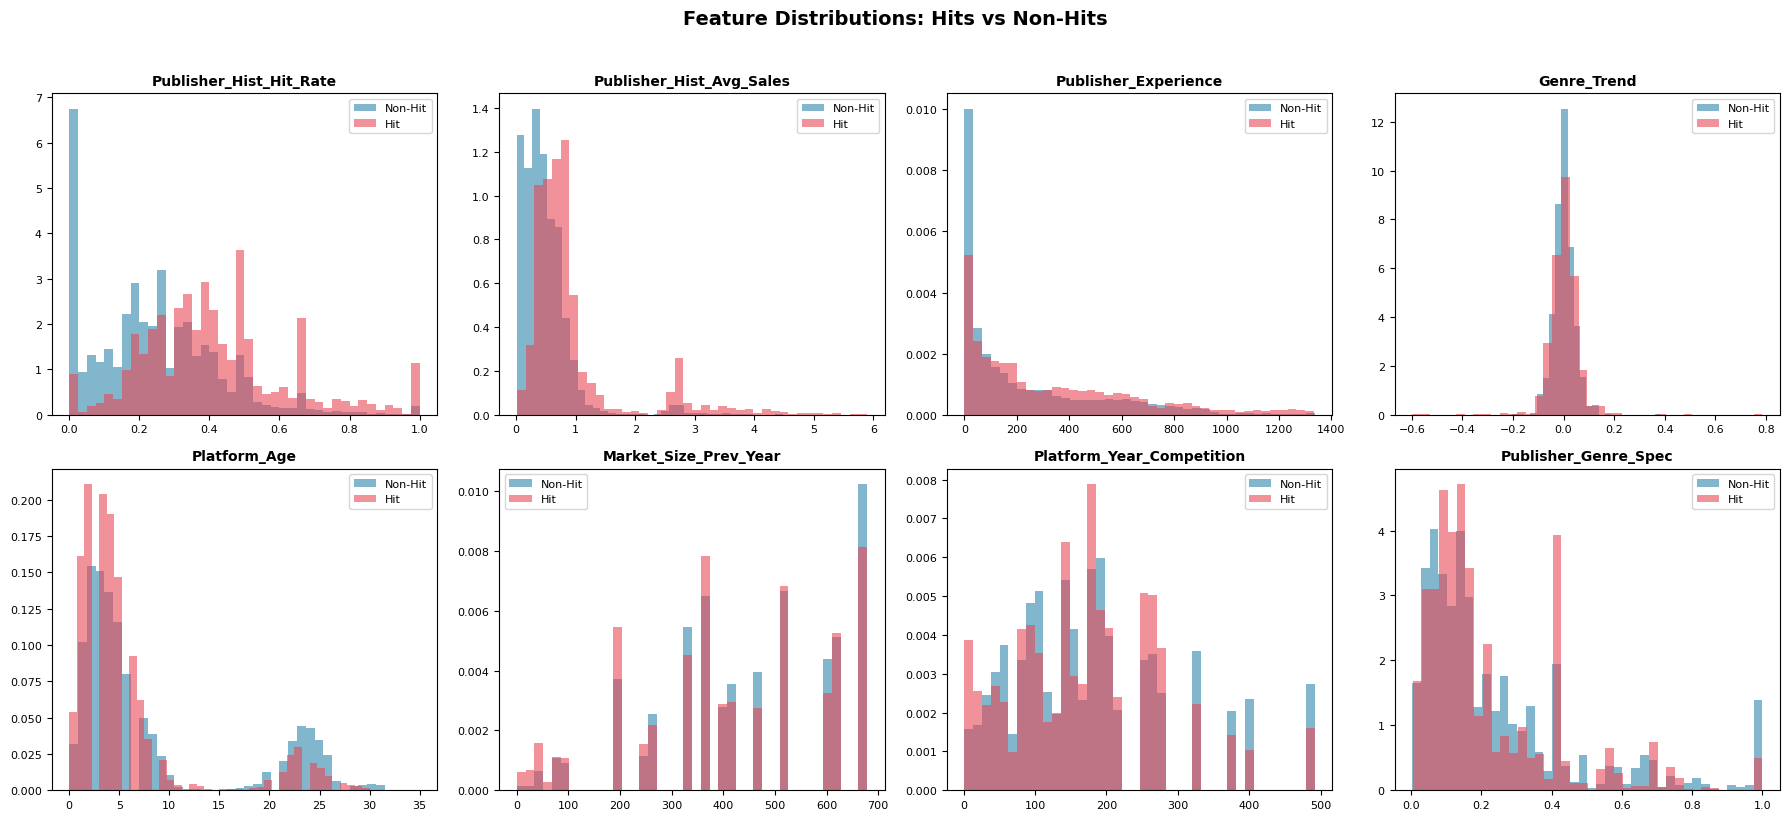

💡 Look for features where the Hit/Non-Hit distributions separate well — those will be your strongest predictors.


In [30]:
# Visualize distributions of key engineered features
key_features = [
    'Publisher_Hist_Hit_Rate', 'Publisher_Hist_Avg_Sales', 'Publisher_Experience',
    'Genre_Trend', 'Platform_Age', 'Market_Size_Prev_Year',
    'Platform_Year_Competition', 'Publisher_Genre_Spec'
]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for ax, feat in zip(axes, key_features):
    # Split by hit/non-hit
    hits = df[df['Is_Hit'] == 1][feat]
    non_hits = df[df['Is_Hit'] == 0][feat]
    
    ax.hist(non_hits, bins=40, alpha=0.6, color='#2E86AB', label='Non-Hit', density=True)
    ax.hist(hits, bins=40, alpha=0.6, color='#E84855', label='Hit', density=True)
    ax.set_title(feat, fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.tick_params(labelsize=8)

fig.suptitle('Feature Distributions: Hits vs Non-Hits', fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

print("💡 Look for features where the Hit/Non-Hit distributions separate well — those will be your strongest predictors.")

## 7. Prepare Phase-Specific Datasets

Each modeling phase needs a different subset of features and a different train/test strategy.

In [32]:
# ============================================================
# PHASE 1: CLASSIFICATION — Hit Prediction
# ============================================================
# Time-based split: Train on games before 2012, test on 2012-2016
# This simulates real-world prediction (can we predict future hits?)

# Features: Only use features that would be KNOWN before release
# (no sales figures, no regional shares — those ARE the outcome)

classification_features = [
    # Categorical (will need encoding)
    'Genre', 'Platform_Gen', 'Publisher_Tier',
    
    # Numerical - historical/lag features
    'Publisher_Hist_Hit_Rate', 'Publisher_Hist_Avg_Sales', 'Publisher_Experience',
    'Genre_Trend', 'Market_Size_Prev_Year',
    
    # Platform features
    'Platform_Age', 'Platform_Hist_Avg_Sales', 'Platform_Year_Competition',
    
    # Interaction features
    'Is_Sequel', 'Publisher_Genre_Spec', 'Years_From_Peak',
    
    # Genre-Region affinity (historical)
    'Genre_NA_Affinity', 'Genre_EU_Affinity', 'Genre_JP_Affinity', 'Genre_Other_Affinity',
]

target_clf = 'Is_Hit'

# Time-based split
SPLIT_YEAR = 2012

train_mask = df['Year'] < SPLIT_YEAR
test_mask = df['Year'] >= SPLIT_YEAR

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['Genre', 'Platform_Gen', 'Publisher_Tier'], drop_first=True)

# Update feature list with encoded columns
cat_originals = ['Genre', 'Platform_Gen', 'Publisher_Tier']
encoded_cols = [c for c in df_encoded.columns if any(c.startswith(cat + '_') for cat in cat_originals)]
numeric_features = [f for f in classification_features if f not in cat_originals]
all_clf_features = numeric_features + encoded_cols

X_train_clf = df_encoded.loc[train_mask, all_clf_features]
y_train_clf = df_encoded.loc[train_mask, target_clf]
X_test_clf = df_encoded.loc[test_mask, all_clf_features]
y_test_clf = df_encoded.loc[test_mask, target_clf]

print("PHASE 1: CLASSIFICATION DATASET")
print(f"  Features: {len(all_clf_features)}")
print(f"  Train: {X_train_clf.shape[0]:,} games (before {SPLIT_YEAR})")
print(f"  Test:  {X_test_clf.shape[0]:,} games ({SPLIT_YEAR}+)")
print(f"  Hit rate — Train: {y_train_clf.mean():.3f} | Test: {y_test_clf.mean():.3f}")
print(f"\n  ⚠️  Class balance check: "
      f"{'IMBALANCED — consider SMOTE or class weights' if y_train_clf.mean() < 0.3 or y_train_clf.mean() > 0.7 else 'Reasonably balanced'}")

PHASE 1: CLASSIFICATION DATASET
  Features: 42
  Train: 13,580 games (before 2012)
  Test:  2,746 games (2012+)
  Hit rate — Train: 0.253 | Test: 0.239

  ⚠️  Class balance check: IMBALANCED — consider SMOTE or class weights


In [33]:
# ============================================================
# PHASE 2: CLUSTERING — Market Segmentation
# ============================================================
# Uses regional sales shares + genre + platform characteristics
# No train/test split needed (unsupervised)

# Filter to games with meaningful sales to avoid noise
MIN_SALES = 0.1  # At least $100K in global sales
df_cluster = df[df['Global_Sales'] >= MIN_SALES].copy()

clustering_features = [
    # Regional sales profiles (shares)
    'NA_Share', 'EU_Share', 'JP_Share',
    
    # Genre affinity
    'Genre_NA_Affinity', 'Genre_EU_Affinity', 'Genre_JP_Affinity',
    
    # Platform & publisher context
    'Platform_Age', 'Publisher_Genre_Spec',
]

X_cluster = df_cluster[clustering_features].copy()

# Standardize for clustering (important for distance-based methods)
from sklearn.preprocessing import StandardScaler
scaler_cluster = StandardScaler()
X_cluster_scaled = pd.DataFrame(
    scaler_cluster.fit_transform(X_cluster),
    columns=clustering_features,
    index=X_cluster.index
)

print("PHASE 2: CLUSTERING DATASET")
print(f"  Features: {len(clustering_features)}")
print(f"  Samples: {X_cluster_scaled.shape[0]:,} games (min ${MIN_SALES}M sales)")
print(f"  Filtered out: {len(df) - len(df_cluster):,} low-sales games")

PHASE 2: CLUSTERING DATASET
  Features: 8
  Samples: 10,649 games (min $0.1M sales)
  Filtered out: 5,677 low-sales games


In [34]:
# ============================================================
# PHASE 3: REGIONAL PREDICTION — Sales Share Prediction
# ============================================================
# Predict what % of sales come from each region
# Same time-based split as Phase 1

regional_features = [
    'Genre', 'Platform_Gen', 'Publisher_Tier',
    'Publisher_Hist_Hit_Rate', 'Publisher_Experience',
    'Genre_Trend', 'Platform_Age',
    'Is_Sequel', 'Publisher_Genre_Spec', 'Years_From_Peak',
    'Genre_NA_Affinity', 'Genre_EU_Affinity', 'Genre_JP_Affinity', 'Genre_Other_Affinity',
]

regional_targets = ['NA_Share', 'EU_Share', 'JP_Share']

# Filter out games with 0 global sales (can't compute shares)
df_regional = df[df['Global_Sales'] > 0].copy()
df_regional_encoded = pd.get_dummies(df_regional, columns=['Genre', 'Platform_Gen', 'Publisher_Tier'], drop_first=True)

# Rebuild feature list with encoded columns
numeric_reg = [f for f in regional_features if f not in cat_originals]
all_reg_features = numeric_reg + [c for c in df_regional_encoded.columns 
                                   if any(c.startswith(cat + '_') for cat in cat_originals)]

train_mask_reg = df_regional_encoded['Year'] < SPLIT_YEAR
test_mask_reg = df_regional_encoded['Year'] >= SPLIT_YEAR

X_train_reg = df_regional_encoded.loc[train_mask_reg, all_reg_features]
X_test_reg = df_regional_encoded.loc[test_mask_reg, all_reg_features]
y_train_reg = df_regional_encoded.loc[train_mask_reg, regional_targets]
y_test_reg = df_regional_encoded.loc[test_mask_reg, regional_targets]

print("PHASE 3: REGIONAL PREDICTION DATASET")
print(f"  Features: {len(all_reg_features)}")
print(f"  Targets: {regional_targets}")
print(f"  Train: {X_train_reg.shape[0]:,} | Test: {X_test_reg.shape[0]:,}")
print(f"\n  Mean regional shares (train):")
for col in regional_targets:
    print(f"    {col}: {y_train_reg[col].mean():.1f}%")

PHASE 3: REGIONAL PREDICTION DATASET
  Features: 38
  Targets: ['NA_Share', 'EU_Share', 'JP_Share']
  Train: 13,580 | Test: 2,746

  Mean regional shares (train):
    NA_Share: 49.2%
    EU_Share: 21.5%
    JP_Share: 22.1%


## 8. Save Processed Datasets

In [36]:
# Save the full feature-engineered dataset
df.to_csv('vgsales_featured.csv', index=False)
print(f"✅ Saved: vgsales_featured.csv ({df.shape[0]:,} rows × {df.shape[1]} cols)")

# Save phase-specific datasets for convenience
import os
os.makedirs('model_data', exist_ok=True)

# Phase 1
X_train_clf.to_csv('model_data/clf_X_train.csv', index=False)
y_train_clf.to_csv('model_data/clf_y_train.csv', index=False)
X_test_clf.to_csv('model_data/clf_X_test.csv', index=False)
y_test_clf.to_csv('model_data/clf_y_test.csv', index=False)
print(f"✅ Saved: Phase 1 classification data (train: {X_train_clf.shape}, test: {X_test_clf.shape})")

# Phase 2
X_cluster_scaled.to_csv('model_data/cluster_X_scaled.csv', index=False)
df_cluster[['Name', 'Genre', 'Platform', 'Publisher', 'Global_Sales']].to_csv(
    'model_data/cluster_metadata.csv', index=False
)
print(f"✅ Saved: Phase 2 clustering data ({X_cluster_scaled.shape})")

# Phase 3
X_train_reg.to_csv('model_data/reg_X_train.csv', index=False)
y_train_reg.to_csv('model_data/reg_y_train.csv', index=False)
X_test_reg.to_csv('model_data/reg_X_test.csv', index=False)
y_test_reg.to_csv('model_data/reg_y_test.csv', index=False)
print(f"✅ Saved: Phase 3 regional prediction data (train: {X_train_reg.shape}, test: {X_test_reg.shape})")

✅ Saved: vgsales_featured.csv (16,326 rows × 35 cols)
✅ Saved: Phase 1 classification data (train: (13580, 42), test: (2746, 42))
✅ Saved: Phase 2 clustering data ((10649, 8))
✅ Saved: Phase 3 regional prediction data (train: (13580, 38), test: (2746, 38))


In [37]:
# Save the scaler for clustering (needed later)
import pickle
with open('model_data/cluster_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_cluster, f)
print("✅ Saved: cluster_scaler.pkl")

✅ Saved: cluster_scaler.pkl


## Summary & Next Steps

### Features Engineered
| # | Feature | Type | Rationale |
|---|---------|------|-----------|
| 1 | `Publisher_Hist_Hit_Rate` | Lag | Publisher's track record of hits |
| 2 | `Publisher_Hist_Avg_Sales` | Lag | Publisher's avg sales performance |
| 3 | `Publisher_Experience` | Cumulative | # of prior games published |
| 4 | `Genre_Trend` | Lag | Is the genre growing or shrinking? |
| 5 | `Market_Size_Prev_Year` | Lag | Overall industry health |
| 6 | `Platform_Age` | Derived | Platform lifecycle position |
| 7 | `Platform_Hist_Avg_Sales` | Lag | Platform's sales track record |
| 8 | `Platform_Year_Competition` | Count | Competition on same platform |
| 9-12 | `Genre_*_Affinity` | Lag | Genre-region historical alignment |
| 13 | `Is_Sequel` | Text-derived | Sequel indicator from title |
| 14 | `Publisher_Genre_Spec` | Interaction | Publisher specialization in genre |
| 15 | `Years_From_Peak` | Derived | Distance from 2008 industry peak |
| 16 | `Decade_Num` | Derived | Numeric decade encoding |

### Data Leakage Prevention
- All historical features use `shift(1)` or previous-year data only
- Time-based train/test split (pre-2012 / 2012+) instead of random split
- No sales figures used as classification features

### Ready for Modeling
- **Phase 1 (Classification):** `model_data/clf_*.csv` → Logistic Regression → Random Forest → XGBoost
- **Phase 2 (Clustering):** `model_data/cluster_*.csv` → K-Means → DBSCAN → interpret segments
- **Phase 3 (Regional):** `model_data/reg_*.csv` → Multi-output regression → regional share prediction